In [5]:
!pip3 install torch torchvision torchaudio
!pip3 install ftfy regex tqdm

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [6]:
import pandas as pd
import os

from transformers import CLIPProcessor

VALSE_PATH = "VALSE_data"

valse_df = pd.read_csv(os.path.join(VALSE_PATH, "valse_challenges_with_img_paths.csv"))

# CLIP

Download VIT B 32 model

In [7]:
#!pip3 install git+https://github.com/openai/CLIP.git

In [16]:
import os
import clip
import torch
import pickle

device = "cpu"
model, preprocess = clip.load('ViT-B/32', device) 

# load processor for SHAP purposes
# CLIP_processor_for_shap = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

In [15]:
torch.save(model, "models/clip_model.pt")
with open("models/clip_preprocess.pkl", "wb") as f:
    pickle.dump(preprocess, f)

In [10]:
# load downloaded model
model = torch.load("models/clip_model.pt", map_location=device)
with open("models/clip_preprocess.pkl", "rb") as f:
    preprocess = pickle.load(f)
#model.eval()

### Prepare one example for CLIP to process

In [11]:
row = valse_df.sample(1)
row.columns

Index(['dataset', 'dataset_idx', 'image_file', 'linguistic_phenomena',
       'caption', 'answer', 'classes', 'split', 'original_split',
       'classes_foil', 'mturk', 'foil', 'challenge_set', 'foil_method',
       'grammaticality_scores', 'nli_scores', 'key', 'declarative_statement',
       'declarative_statement_foils', 'provenance_of_foils', 'foiling_method',
       'orig_caption', 'only_caption', 'local_img_path'],
      dtype='object')

In [12]:
image_path, caption, foil = os.path.join(VALSE_PATH, row.local_img_path.iloc[0]), row["caption"].iloc[0], row["foil"].iloc[0]

In [13]:
from PIL import Image

image = Image.open(image_path)
image_input = preprocess(image).unsqueeze(0).to(device)
image_input.shape

ValueError: text input must of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

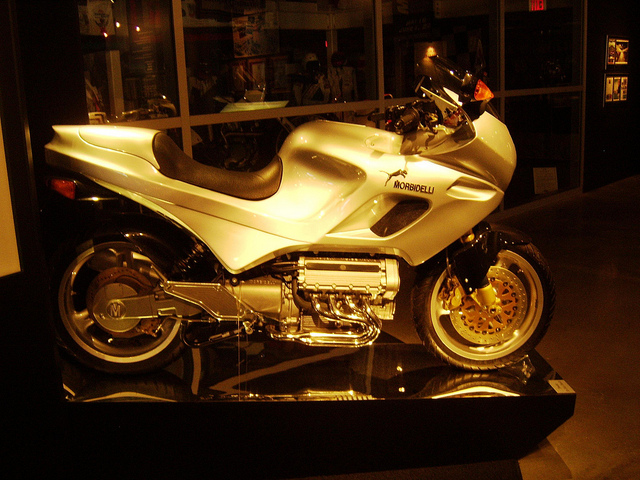

In [ ]:
image

In [ ]:
text_inputs = torch.cat([clip.tokenize(caption), clip.tokenize(foil) ], dim = 0).to(device)

In [ ]:
text_inputs

tensor([[49406,   585,   568,  1626,   531,  2330,  5903,   589, 10297,   533,
         30987,   541,  7755,   269,   706,   533,   585,   320,  1674,   539,
           761,   320, 10297,   286,  1958,   269, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   585,   568,  1626,   531,  2330,  5903,   589, 10297,   533,
         30987,   541,  7755,   269,   706,   533,   585,   320,  1674,   539,
           761,   320, 10297,   286,   871,   269, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0, 

In [ ]:
# Calculate features
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)

### Predict

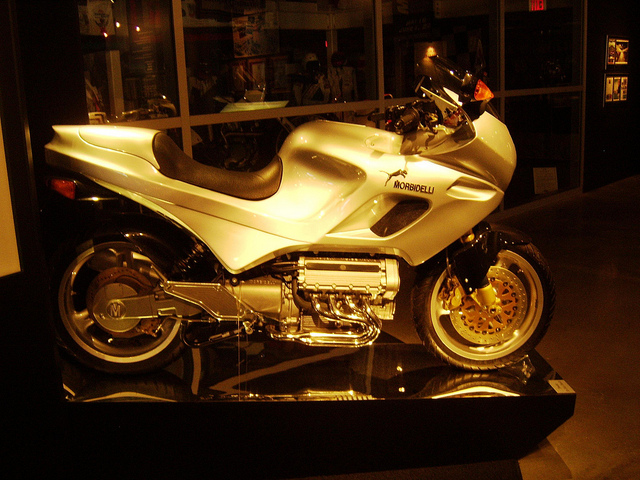


Top predictions:

it's hard to tell whether this motorcycle is futuristic or retro. so is it a picture of just a motorcycle? yes.: 50.04%
it's hard to tell whether this motorcycle is futuristic or retro. so is it a picture of just a motorcycle? no.: 49.96%


In [ ]:
# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(2)

# Print the result
display(image)
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{[caption, foil][index]:>16s}: {100 * value.item():.2f}%")

# X-VLM